## 导入必要的包

In [1]:
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch

torch.__version__

'1.6.0'

## 自编码网络

### 参数与数据

设置超参数

In [2]:
torch.manual_seed(1)

EPOCH = 100
BATCH_SIZE = 256
LR = 0.0005
N_TEST_IMG = 10

设置数据集

In [3]:
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=False,
)

train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

print('训练集数据维度: ', train_data.data.size(), '\n训练集标签维度: ', train_data.targets.size())

训练集数据维度:  torch.Size([60000, 28, 28]) 
训练集标签维度:  torch.Size([60000])


捕捉设备

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


### 网络构建

In [5]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 12),
            nn.Tanh(),
            nn.Linear(12, 3))

        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid())
    
    def forward(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)

        return encoded, decoded

查看模型摘要

In [6]:
from torchsummary import summary

autoencoder = AutoEncoder().to(device)
summary(autoencoder, input_size=(28 * 28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
              Tanh-2                  [-1, 128]               0
            Linear-3                   [-1, 64]           8,256
              Tanh-4                   [-1, 64]               0
            Linear-5                   [-1, 12]             780
              Tanh-6                   [-1, 12]               0
            Linear-7                    [-1, 3]              39
            Linear-8                   [-1, 12]              48
              Tanh-9                   [-1, 12]               0
           Linear-10                   [-1, 64]             832
             Tanh-11                   [-1, 64]               0
           Linear-12                  [-1, 128]           8,320
             Tanh-13                  [-1, 128]               0
           Linear-14                  [

设置优化器和损失函数

In [7]:
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
loss_func = nn.MSELoss()

开始训练

In [8]:
view_data = train_data.data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.
img_data = view_data.numpy()
view_data = view_data.to(device)

step_loss_list = []
decoded_img_list = []
epoch_loss_list = []

for epoch in range(EPOCH):
    for step, (x, _) in enumerate(train_loader):
        train_x = x.view(-1, 28 * 28).to(device)
        encoded, decoded = autoencoder(train_x)
        loss = loss_func(decoded, train_x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        step_loss_list.append(loss.item())
    if (epoch + 1) % 5 == 0:
        print('Epoch: %2d' % (epoch + 1), '| train loss: %.4f' % np.mean(step_loss_list))
    epoch_loss_list.append(np.mean(step_loss_list))
    _, decoded_data = autoencoder(view_data)
    decoded_img_list.append(decoded_data)

Epoch:  5 | train loss: 0.0700
Epoch: 10 | train loss: 0.0634
Epoch: 15 | train loss: 0.0583
Epoch: 20 | train loss: 0.0537
Epoch: 25 | train loss: 0.0503
Epoch: 30 | train loss: 0.0478
Epoch: 35 | train loss: 0.0459
Epoch: 40 | train loss: 0.0444
Epoch: 45 | train loss: 0.0431
Epoch: 50 | train loss: 0.0421
Epoch: 55 | train loss: 0.0412
Epoch: 60 | train loss: 0.0404
Epoch: 65 | train loss: 0.0397
Epoch: 70 | train loss: 0.0392
Epoch: 75 | train loss: 0.0386
Epoch: 80 | train loss: 0.0382
Epoch: 85 | train loss: 0.0377
Epoch: 90 | train loss: 0.0373
Epoch: 95 | train loss: 0.0370
Epoch: 100 | train loss: 0.0367


## 可视化

### 损失函数可视化

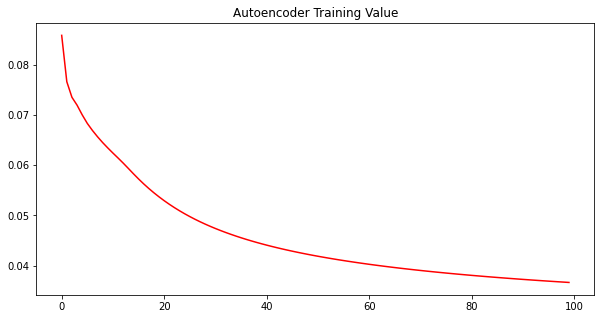

In [18]:
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.plot(epoch_loss_list, color=(1, 0, 0))
plt.title('Autoencoder Training Value')
plt.show()

### 动图可视化

In [9]:
import imageio
import cv2

concat_img = []
black = np.zeros([28, 1])
anim_file = 'media/autoencoder.gif'

img_raw = np.hstack((img_data[0].reshape(28, 28) * 255, black,
                     img_data[1].reshape(28, 28) * 255, black,
                     img_data[2].reshape(28, 28) * 255, black,
                     img_data[3].reshape(28, 28) * 255, black,
                     img_data[4].reshape(28, 28) * 255, black,
                     img_data[5].reshape(28, 28) * 255, black,
                     img_data[6].reshape(28, 28) * 255, black,
                     img_data[7].reshape(28, 28) * 255, black,
                     img_data[8].reshape(28, 28) * 255, black,
                     img_data[9].reshape(28, 28) * 255)).astype('uint8')
size = (int(img_raw.shape[1] * 2.4), int(img_raw.shape[0] * 2.4))
img_raw = cv2.resize(img_raw, size)

with imageio.get_writer(anim_file, mode='I') as writer:
    for i in range(len(decoded_img_list)):
        img_decode = np.hstack((decoded_img_list[i].cpu().detach().numpy()[0].reshape(28, 28) * 255, black,
                         decoded_img_list[i].cpu().detach().numpy()[1].reshape(28, 28) * 255, black,
                         decoded_img_list[i].cpu().detach().numpy()[2].reshape(28, 28) * 255, black,
                         decoded_img_list[i].cpu().detach().numpy()[3].reshape(28, 28) * 255, black,
                         decoded_img_list[i].cpu().detach().numpy()[4].reshape(28, 28) * 255, black,
                         decoded_img_list[i].cpu().detach().numpy()[5].reshape(28, 28) * 255, black,
                         decoded_img_list[i].cpu().detach().numpy()[6].reshape(28, 28) * 255, black,
                         decoded_img_list[i].cpu().detach().numpy()[7].reshape(28, 28) * 255, black,
                         decoded_img_list[i].cpu().detach().numpy()[8].reshape(28, 28) * 255, black,
                         decoded_img_list[i].cpu().detach().numpy()[9].reshape(28, 28) * 255)).astype('uint8')
        img_decode = cv2.resize(img_decode, size)
        img = np.vstack((img_raw, img_decode))
        writer.append_data(img)

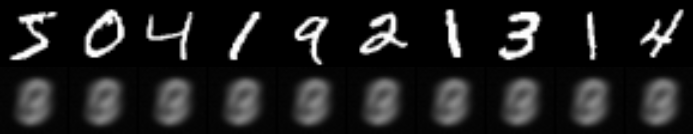

In [10]:
from IPython import display

display.Image(filename=anim_file)

### 三维分布可视化

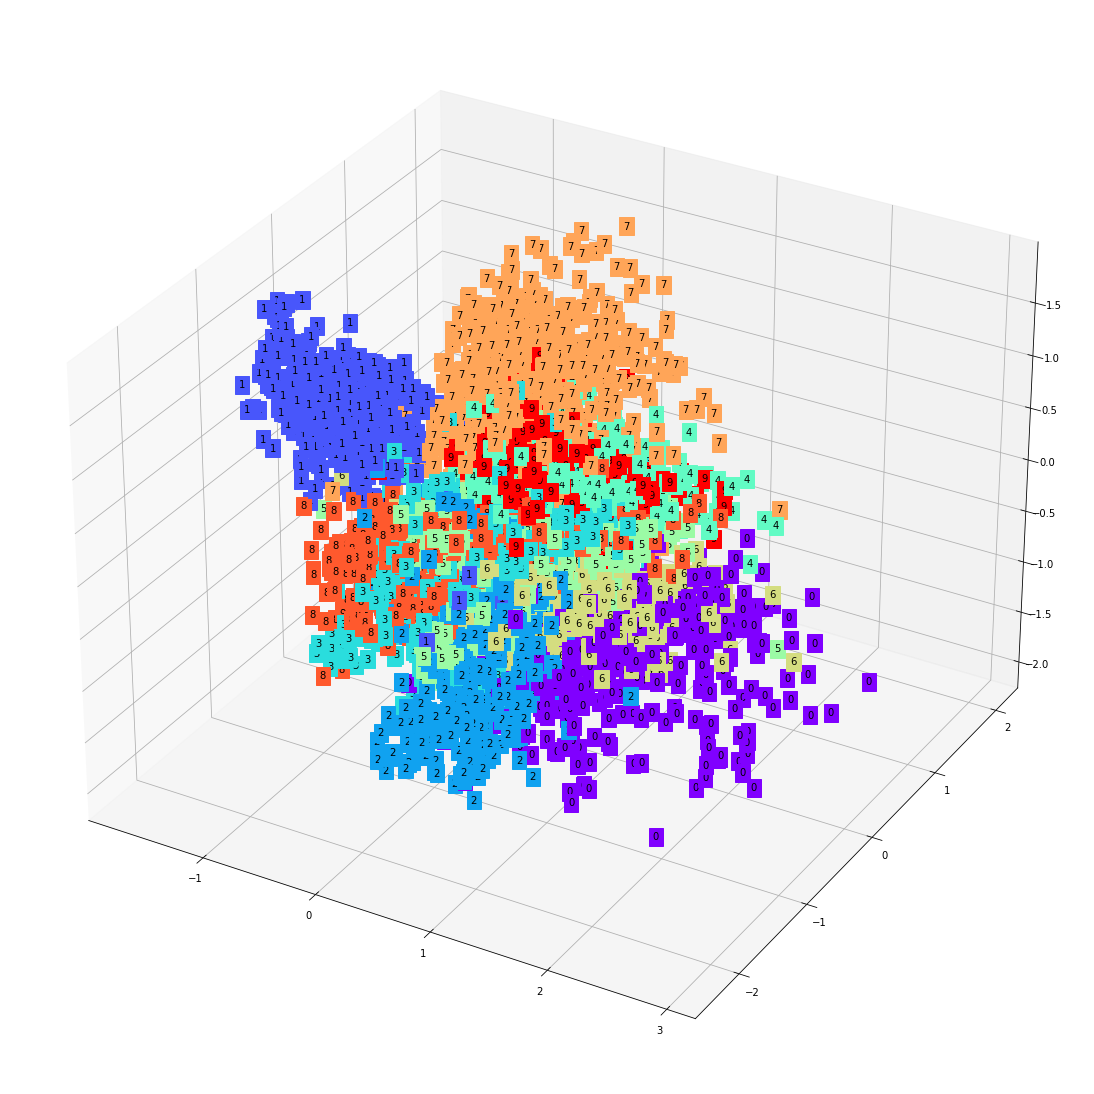

In [14]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


view_data = train_data.data[:5000].view(-1, 28*28).type(torch.FloatTensor) / 255.
view_data = view_data.to(device)
encoded_data, _ = autoencoder(view_data)
fig = plt.figure(2)
fig.set_size_inches(15, 15)
ax = Axes3D(fig)
X, Y, Z = encoded_data.cpu().detach().numpy()[:, 0], encoded_data.cpu().detach().numpy()[:, 1], encoded_data.cpu().detach().numpy()[:, 2]
values = train_data.targets[:5000].numpy()
for x, y, z, s in zip(X, Y, Z, values):
    c = cm.rainbow(int(255 * s / 9))
    ax.text(x, y, z, s, backgroundcolor=c)
ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(), Z.max())
plt.show()